In [40]:
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics 
%matplotlib inline 

In [2]:
def tissue_average_dataframe(spec_donors=[],reject_donors=[],donor_sex=None,donor_age=[],spec_tissues=[],reject_tissues=[],
                       top_tissues=None,min_tissue_count=None,output_name=None):
    
    #        This function constructs a pandas dataframe with ~10000 rows (transcripts) and a column for each tissue.
    #        Each column is the average of all columns of the same tissue.

    #        Most of the code is copied from functions in PCA_and_plot, so look there for details.
    #        Again here, one can select which donors, sexes, ages, and tissues are included.

    # DONORS BY ID
    if not spec_donors:
        all_donors = open('../data/donors_list.txt')
        donor_list = [ID[0:-1] for ID in all_donors if ID[0:-1] not in reject_donors]
        all_donors.close()
    else:
        donor_list = spec_donors
    # dictionary of donor IDs, and an array that will be [sex,age]
    donor_dict = dict((ID,[]) for ID in donor_list)

    # DONORS BY AGE AND SEX
    donor_info = open('../data/donor_info.txt')
    for line in donor_info:
        # info is [ID,sex,age,death]
        info = line.split('\t')
        if info[0] in donor_list:
            # check sex
            if donor_sex and info[1] != donor_sex:
                del donor_dict[info[0]]
                continue
            else:
                donor_dict[info[0]].append(info[1])
            # check age    
            age = info[2].split('-')[0]
            if donor_age and age not in donor_age:
                del donor_dict[info[0]]
                continue
            else:
                donor_dict[info[0]].append(age)
    donor_info.close()

    # TISSUES BY TYPE AND SAMPLE COUNT
    tissues = Counter()
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata_Enhanced/donor_meta_'+ID+'.txt')
        # skip header lines
        next(metafile)
        next(metafile)
        next(metafile)
        next(metafile)
        for line in metafile:
            # look for tissue type listed in meta file
            tissue = line.split('\t')[1]
            if spec_tissues and tissue in spec_tissues:
                tissues[tissue] = tissues.get(tissue,0) + 1
            elif not spec_tissues and tissue not in reject_tissues:
                tissues[tissue] = tissues.get(tissue,0) + 1
        metafile.close()
    if min_tissue_count:
        # pick tissues with minimum number of samples
        tissue_list = [key for key,value in tissues.iteritems() if value >= min_tissue_count]
    else:
        # pick top most commonly sampled tissues
        tissue_list = [key for key,value in tissues.most_common(top_tissues)]

    # CONSTRUCT MATRIX
    avg_matrix = np.zeros((10000,len(tissue_list)))

    # metadata on relevant points
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata_Enhanced/donor_meta_'+ID+'.txt')
        next(metafile)
        next(metafile)
        next(metafile)
        next(metafile)
        # column indices and types for relevant tissues
        columns = []
        column_tissue = []
        column = 0
        for line in metafile:
            tissue = line.split('\t')[1]
            if tissue in tissue_list:
                columns.append(column)
                column_tissue.append(tissue)
            column = column + 1
        metafile.close()
        # get data
        donor_matrix = np.zeros((10000,len(columns)))
        row = 0
        donorfile = open('../data/donor_matrices_fixed/donor_'+ID+'.txt')
        for line in donorfile:
            # from file, take desired tissue columns
            values = [line.split('\t')[ind] for ind in columns]
            # add them to appropriate columns of avg_matrix
            indices = [tissue_list.index(col_tis) for col_tis in column_tissue]
            avg_matrix[row,indices] = avg_matrix[row,indices] + [float(value) for value in values]
            row = row+1
        donorfile.close()
    
    # divide by number of samples to get average
    for col in range(len(tissue_list)):
        avg_matrix[:,col] = avg_matrix[:,col]/tissues[tissue_list[col]]

    df = pd.DataFrame(avg_matrix,columns=tissue_list)
    # save to file
    if output_name:
        df.to_csv(output_name,sep='\t')
        print 'Dataframe saved as ' + output_name
    return df

In [4]:
df = tissue_average_dataframe(output_name ='../data/mean_expression_in_tissue')

Dataframe saved as ../data/mean_expression_in_tissue


In [18]:
df = pd.read_csv('../data/mean_expression_in_tissue',sep='\t')
print df.size
sorteddf = df.reindex_axis(sorted(df.columns), axis=1).drop('Unnamed: 0', 1)
sorteddf.describe()


540000


Adipose - Subcutaneous  Adipose - Visceral (Omentum)  Adrenal Gland  \
count            10000.000000                  10000.000000   10000.000000   
mean                52.518384                     58.004903      62.068734   
std                418.669826                    529.248389     837.962321   
min                  0.000000                      0.000000       0.000000   
25%                  1.685731                      2.160303       1.305242   
50%                 13.171742                     13.747201      10.290681   
75%                 32.079672                     32.484277      31.079496   
max              21801.247816                  27040.479470   41956.896767   

       Artery - Aorta  Artery - Coronary  Artery - Tibial       Bladder  \
count    10000.000000       10000.000000     10000.000000  10000.000000   
mean        51.230506          53.424958        51.052558     49.296761   
std        278.304027         325.990836       300.039607    378.532133   
min          0.000000           0.000000         0.000000      0.000000   
25%          1.375928           2.029173         1.052564      1.983690   
50%         11.784379          13.211024        10.915521     12.828150   
75%         32.936743          32.874248        31.944184     31.938318   
max      10343.211947       13597.758053     10949.681111  18666.410245   

       Brain - Amygdala  Brain - Anterior cingulate cortex (BA24)  \
count      10000.000000                              10000.000000   
mean          60.813902                                 60.126589   
std         1172.227467                               1130.059430   
min            0.000000                                  0.000000   
25%            0.932429                                  0.850956   
50%            7.596159                                  7.615483   
75%           23.205265                                 25.693528   
max        67044.668416                              63030.793527   

       Brain - Caudate (basal ganglia)      ...        \
count                     10000.000000      ...         
mean                         60.016414      ...         
std                        1136.600318      ...         
min                           0.000000      ...         
25%                           1.037667      ...         
50%                           8.046915      ...         
75%                          24.089491      ...         
max                       62044.546566      ...         

       Skin - Not Sun Exposed (Suprapubic)  Skin - Sun Exposed (Lower leg)  \
count                         10000.000000                    10000.000000   
mean                             53.470476                       61.608627   
std                             455.478396                     1012.534659   
min                               0.000000                        0.000000   
25%                               1.856705                        1.948796   
50%                              10.994361                       11.258148   
75%                              29.068575                       29.785730   
max                           24704.626442                    92670.438684   

       Small Intestine - Terminal Ileum        Spleen       Stomach  \
count                      10000.000000  10000.000000  10000.000000   
mean                          54.840482     54.168329     66.470258   
std                          641.480224    449.381755    932.869978   
min                            0.000000      0.000000      0.000000   
25%                            2.527249      1.264542      2.106440   
50%                           11.912897     11.563825     10.113258   
75%                           28.520778     32.732426     24.557426   
max                        32001.976618  25997.274411  41044.451238   

             Testis       Thyroid        Uterus        Vagina    Whole Blood  
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.

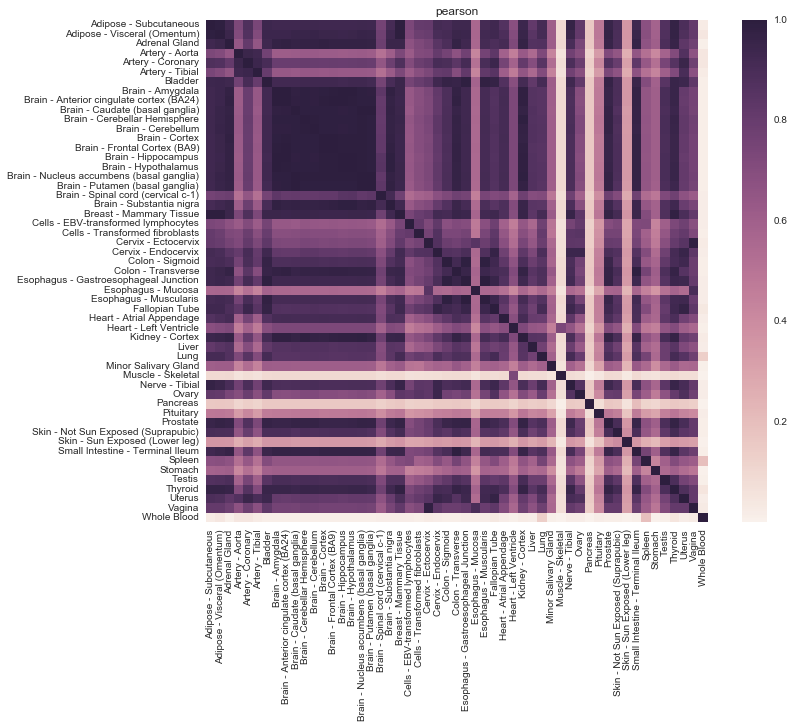

In [24]:
method = 'pearson' 
corrmat = sorteddf.corr(method)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, ax=ax)
ax.set_title(method)


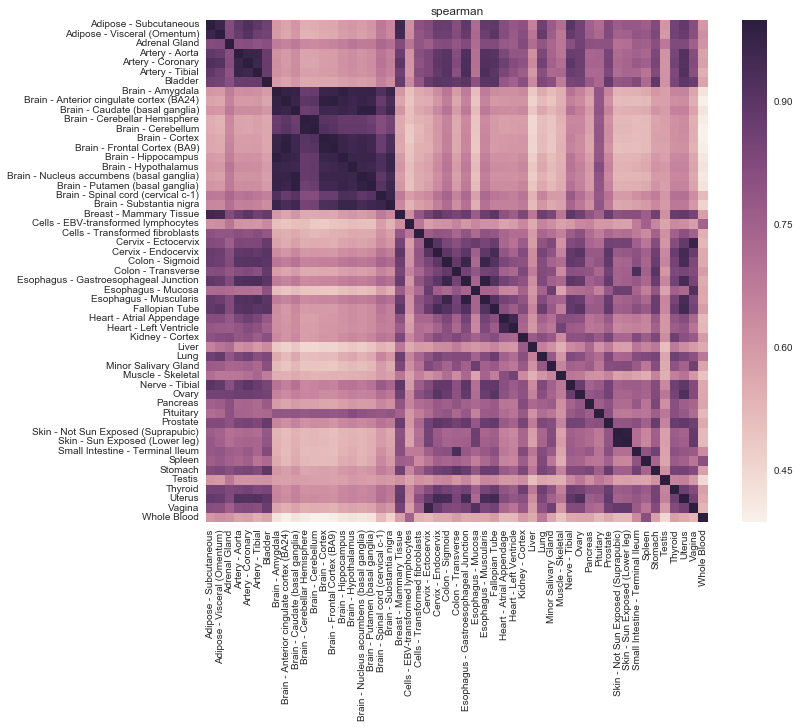

In [27]:
method = 'spearman' 
corrmat = sorteddf.corr(method)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True, ax=ax)
ax.set_title(method)

In [ ]:
distmet = "euclidean"
distmat = sklearn.metrics.pairwise.pairwise_distances(sorteddf.as_matrix().transpose(),metric=distmet)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(distmat, vmax=1, square=True, ax=ax)
ax.set_title(distmet)
